In [30]:
from ortools.linear_solver import pywraplp
from datetime import datetime, date
import pandas as pd
import calendar

solver = pywraplp.Solver("Mixed Integer Programming", pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

# Variáveis do problema

## 1. Data

In [31]:
# Índice do mês da escala a ser montada (1-12)
month_idx = 11

# Pegando o número de dias e a lista com os índices do dia da semana correspondente
now = datetime.now()
n_days = calendar.monthrange(now.year, month_idx)[1]
weekdays  = [date(now.year, month_idx, d).weekday() for d in range(1, n_days + 1)]
first_weekday = weekdays[0]

# Printando o número de semanas existente no mês (necessário para a lista da enfermaria)
n_weeks = len(calendar.monthcalendar(now.year, month_idx))
print(n_weeks)

# Carga horária semanal máxima de trabalho por residente
max_workload = 120

5


## 2. Residentes

In [32]:
residents = [
    { "idx": 0, "name": "André", "type": "R1" },
    { "idx": 1, "name": "Maria", "type": "R1" },
    { "idx": 2, "name": "Cinthya", "type": "R1" },
    { "idx": 3, "name": "Rolando", "type": "R1" },
    { "idx": 4, "name": "Victor", "type": "R1" },
    { "idx": 5, "name": "Lucas", "type": "R2" },
    { "idx": 6, "name": "Giselia", "type": "R2" },
    { "idx": 7, "name": "Pedro", "type": "R2" },
    { "idx": 8, "name": "Bárbara", "type": "R2" },
    { "idx": 9, "name": "Douglas", "type": "R2" },
    { "idx": 10, "name": "Filipe", "type": "R3" },
    { "idx": 11, "name": "Berbem", "type": "R2_HFA" },
    { "idx": 12, "name": "Douglas HFA", "type": "R2_HFA" },
    { "idx": 13, "name": "Vitória HFA", "type": "R1_HFA" },
]

n_res = len(residents)

# Tipos de residente para a métrica de justiça
# (residentes do HFA não entram)
res_types= ['R1', 'R2', 'R3']
n_types = len(res_types)

### 2.1 Lista de R1s responsáveis por cada semana da enfermaria

In [33]:
enf_list = ['André', 'Maria', 'Cinthya', 'Rolando', 'Victor']
enf_list = [r for r in residents if r['name'] in enf_list]
enf_list

[{'idx': 0, 'name': 'André', 'type': 'R1'},
 {'idx': 1, 'name': 'Maria', 'type': 'R1'},
 {'idx': 2, 'name': 'Cinthya', 'type': 'R1'},
 {'idx': 3, 'name': 'Rolando', 'type': 'R1'},
 {'idx': 4, 'name': 'Victor', 'type': 'R1'}]

## 3. Plantões

In [34]:
shifts = [
    { "idx": 0, "name": "HRC_dia", "start_time": 7, "end_time": 19, "frequency": [1,1,1,1,1,1,1], "num_res": 2 },
    { "idx": 1, "name": "HRC_noite", "start_time": 19, "end_time": 7, "frequency": [1,1,1,1,1,1,1], "num_res": 2 },
    { "idx": 2, "name": "ENF", "start_time": 7, "end_time": 19, "frequency": [1,1,1,1,1,1,1], "num_res": 2 },
    { "idx": 3, "name": "CC", "start_time": 7, "end_time": 19, "frequency": [1,1,1,1,1,0,0], "num_res": 2 },
    { "idx": 4, "name": "HRSam", "start_time": 19, "end_time": 24, "frequency": [1,1,1,0,0,0,0], "num_res": 2 },
    { "idx": 5, "name": "Amb", "start_time": 7, "end_time": 19, "frequency": [1,1,1,1,1,0,0], "num_res": 1 },
]

n_shifts = len(shifts)

## 4. Matriz de choque de horário

In [35]:
def convert_date(hour, day=1):
    return datetime.now().replace(day=day, hour=hour-1, minute=0, second=0, microsecond=0)

def get_time(shift):
    start = shift['start_time']
    end = shift['end_time']
    if end < start:
        return convert_date(start), convert_date(end, 2)
    return convert_date(start), convert_date(end)

def check_overlap(s1, s2):
    start1, end1 = get_time(s1)
    start2, end2 = get_time(s2)
    if end1 > start2 and end2 > start1:
        return 1

    return 0

overlaps = [[check_overlap(s1, s2) for s1 in shifts] for s2 in shifts]
overlaps

[[1, 0, 1, 1, 0, 1],
 [0, 1, 0, 0, 1, 0],
 [1, 0, 1, 1, 0, 1],
 [1, 0, 1, 1, 0, 1],
 [0, 1, 0, 0, 1, 0],
 [1, 0, 1, 1, 0, 1]]

In [36]:
for i, shift in enumerate(shifts):
    start, end = get_time(shift)
    shifts[i]['workload'] = (end - start).seconds//3600

## Variáveis de decisão

In [37]:
# Variável binária que guarda a escala do mês
# r: residente
# s: plantão
# d: dia do mês
Xrsd = [[[solver.BoolVar(f'X{r}_{s}_{d}') for d in range(n_days)] for s in range(n_shifts)] for r in range(n_res)]

# Variável que guarda a carga horária semanal de cada residente
# r: residente
# w: semana
Hrw = [[solver.NumVar(0, max_workload, f'H{r}_{w}') for w in range(n_weeks)] for r in range(n_res)]

# Somatório da carga horária semanal de todos os residentes por semana para cada tipo de residente
# t: tipo de residente
# w: semana
Stw = [[solver.NumVar(0, solver.infinity(), f'S{t}_{w}') for w in range(n_weeks)] for t in range(n_types)]

# Ligando variáveis de decisão

In [38]:
# Carga horária semanal por residente -> Hrw
for r, resident in enumerate(residents):
    week_counter = 0
    for d, weekday in enumerate(weekdays):
        if weekday == first_weekday:
            ct = solver.Constraint(0, 0, f"workload - resident {resident['name']} - week {week_counter}")
            ct.SetCoefficient(Hrw[r][week_counter], -1)
            week_counter += 1

        for s, shift in enumerate(shifts):
            ct.SetCoefficient(Xrsd[r][s][d], shift['workload'])

In [39]:
# Somatório da carga horária semanal dos residentes por semana -> Stw
for w in range(n_weeks):
    for t in range(n_types):
        res_list = [r for r in residents if r['type'] == res_types[t]]
        ct = solver.Constraint(0,0, f"Workload sum - week {w} - res_type {t}")
        ct.SetCoefficient(Stw[t][w], -1)
        for res in res_list:
            ct.SetCoefficient(Hrw[res['idx']][w], 1)

# Métrica de justiça de carga horária

In [40]:
precision = 0.65

for w in range(n_weeks):
    for t in range(n_types):
        res_list = [r for r in residents if r['type'] == res_types[t]]
        N = len(res_list)
        for res in res_list:
            # Limites superiores
            ct_upper = solver.Constraint(-solver.infinity(), 0, f"Upper limit - week {w} - res_type {t} - resident {res['idx']}: {res['name']}")
            ct_upper.SetCoefficient(Hrw[res['idx']][w], N)
            ct_upper.SetCoefficient(Stw[t][w], -(1+precision))

            # Limites inferiores
            ct_lower = solver.Constraint(0, solver.infinity(), f"Lower limit - week {w} - res_type {t} - resident {res['idx']}: {res['name']}")
            ct_lower.SetCoefficient(Hrw[res['idx']][w], N)
            ct_lower.SetCoefficient(Stw[t][w], -(1-precision))

# Restrições
## 1. Garantir que tenha o número de residentes necessário em cada plantão

In [41]:
for s, shift in enumerate(shifts):
    for d, weekday in enumerate(weekdays):

        # Find the number of residents depending on weekday
        num_res = 0
        if shift['frequency'][weekday]:
            num_res = shift['num_res']

        ct = solver.Constraint(num_res, num_res, f"Day {d + 1} - {num_res} residents in {shift['name']}")
        soma = ""
        for r in range(n_res):
            ct.SetCoefficient(Xrsd[r][s][d], 1)

## 2. Garantir que não haja choque de horário na escala

In [42]:
for d in range(n_days):
    for r, resident in enumerate(residents):
        for shift_idx, shift in enumerate(shifts):
            ct = solver.Constraint(0, 1, f"No time overlap in day {d + 1} for resident {resident['name']} - Shift {shift['name']}")
            for s, overlap in enumerate(overlaps[shift_idx]):
                ct.SetCoefficient(Xrsd[r][s][d], overlap)

## 3. Ambulatório só tem R1

In [43]:
s = 5
shift = shifts[s]
r_mais = [res for res in residents if res['type'] in ["R2", "R3", "R2_HFA"]]

for d in range(n_days):
    for resident in r_mais:
        r = resident['idx']
        ct = solver.Constraint(0, 0, f"No r+ in ambulatory - day {d + 1} - resident {resident['name']}")
        ct.SetCoefficient(Xrsd[r][s][d], 1)

## 4. HRC_dia/noite, HRSam, ENF e CC precisa de um R1 e um R2/R3 por turno

In [44]:
for d in range(n_days):
    for s, shift in enumerate(shifts[:-1]):
        ct = solver.Constraint(0, 0, f"R1+R2/R3 in day {d + 1} - shift {shift['name']}")
        for r, resident in enumerate(residents):
            is_r1 = 1 if resident['type'] in ['R1', 'R1_HFA'] else -1
            ct.SetCoefficient(Xrsd[r][s][d], is_r1)

## 5. Residentes do HFA só fazem HRC noite/dia -> terça, quinta ou domingo

In [45]:
hfa_shifts = ['HRC_noite']
non_hfa_shifts = [shift for shift in shifts if shift['name'] not in hfa_shifts]
hfa_res = [res for res in residents if res['type'] in ["R1_HFA", "R2_HFA"]]
non_hfa_weekdays = [0, 2, 4, 5]

for d, weekday in enumerate(weekdays):
    if weekday in non_hfa_weekdays:
        for shift in shifts:
            for res in hfa_res:
                ct = solver.Constraint(
                    0, 0, f"No HFA in weekday {weekday} - shift {shift['name']} - day {d + 1} - resident {res['idx']}: {res['name']}")
                ct.SetCoefficient(Xrsd[res['idx']][shift['idx']][d], 1)

    for shift in non_hfa_shifts:
        for res in hfa_res:
            ct = solver.Constraint(
                0, 0, f"No HFA in shift {shift['name']} - day {d + 1} - resident {res['idx']}: {res['name']}")
            ct.SetCoefficient(Xrsd[res['idx']][shift['idx']][d], 1)


## 6. R3 faz HRC_dia ou CC 1x por semana cada

In [46]:
r3_shifts = [shifts[i] for i in [0, 3]]
r3_list = [res for res in residents if res['type']  == "R3"]

for resident in r3_list:
    r = resident['idx']
    for shift in r3_shifts:
        s = shift['idx']
        week_counter = 0
        for d, weekday in enumerate(weekdays):
            if weekday == first_weekday:
                week_counter += 1
                ct = solver.Constraint(1, 1, f"R3 {resident['name']} working once in shift {shift['name']} - week {week_counter}")
            ct.SetCoefficient(Xrsd[r][s][d], 1)

## 7. R3 não faz parte dos demais plantões (HRC_noite, amb, enf, hrsam)

In [47]:
not_r3_shifts = [shifts[i] for i in [1, 2, 4, 5]]

ct = solver.Constraint(0, 0, f"R3 residents doesnt work in other shifts")
for resident in r3_list:
    r = resident['idx']
    for shift in not_r3_shifts:
        s = shift['idx']
        for d in range(n_days):
            ct.SetCoefficient(Xrsd[r][s][d], 1)

## 8. O R1 fica a semana toda na enfermaria

In [48]:
week_counter = 0
s = 2  # ENF

for d, weekday in enumerate(weekdays):
    if weekday == first_weekday:
        resident = enf_list[week_counter]
        r = resident['idx']
        week_counter += 1
    ct = solver.Constraint(1, 1, f"R1 {resident['name']} working on ENF - week {week_counter + 1} - day {d}")
    ct.SetCoefficient(Xrsd[r][s][d], 1)

## Função objetivo

In [49]:
objective = solver.Objective()

for t in range(n_types):
    for w in range(n_weeks):
        objective.SetCoefficient(Stw[t][w], 1)

objective.SetMinimization()

In [50]:
solver.NumConstraints()

4082

In [51]:
status = solver.Solve()

if status == pywraplp.Solver.OPTIMAL:
    print('OTIMA')

OTIMA


In [52]:
if status == pywraplp.Solver.OPTIMAL:
    r = 10
    resident = residents[r]

    # for r, resident in enumerate(residents):
    print(resident['name'])

    for d in range(n_days):
        for s, shift in enumerate(shifts[:-1]):
            if round(Xrsd[r][s][d].solution_value(), 0):
                print(f"DIA {d + 1} - {shift['name']}")

Filipe
DIA 5 - CC
DIA 6 - HRC_dia
DIA 9 - HRC_dia
DIA 11 - CC
DIA 15 - HRC_dia
DIA 17 - CC
DIA 25 - CC
DIA 27 - HRC_dia
DIA 29 - HRC_dia
DIA 30 - CC


In [53]:
if status == pywraplp.Solver.OPTIMAL:
    for r, resident in enumerate(residents):
        print(f"\nRESIDENTE {resident['name']}")
        for w in range(n_weeks):
            print(f"Semana {w + 1}: {round(Hrw[r][w].solution_value(), 0)}")


RESIDENTE André
Semana 1: 84.0
Semana 2: 106.0
Semana 3: 48.0
Semana 4: 60.0
Semana 5: 36.0

RESIDENTE Maria
Semana 1: 36.0
Semana 2: 108.0
Semana 3: 48.0
Semana 4: 36.0
Semana 5: 34.0

RESIDENTE Cinthya
Semana 1: 60.0
Semana 2: 36.0
Semana 3: 108.0
Semana 4: 29.0
Semana 5: 12.0

RESIDENTE Rolando
Semana 1: 94.0
Semana 2: 41.0
Semana 3: 111.0
Semana 4: 113.0
Semana 5: 12.0

RESIDENTE Victor
Semana 1: 77.0
Semana 2: 60.0
Semana 3: 36.0
Semana 4: 113.0
Semana 5: 24.0

RESIDENTE Lucas
Semana 1: 24.0
Semana 2: 60.0
Semana 3: 84.0
Semana 4: 84.0
Semana 5: 12.0

RESIDENTE Giselia
Semana 1: 84.0
Semana 2: 29.0
Semana 3: 24.0
Semana 4: 84.0
Semana 5: 12.0

RESIDENTE Pedro
Semana 1: 24.0
Semana 2: 77.0
Semana 3: 48.0
Semana 4: 29.0
Semana 5: 12.0

RESIDENTE Bárbara
Semana 1: 53.0
Semana 2: 24.0
Semana 3: 87.0
Semana 4: 46.0
Semana 5: 17.0

RESIDENTE Douglas
Semana 1: 82.0
Semana 2: 77.0
Semana 3: 24.0
Semana 4: 24.0
Semana 5: 17.0

RESIDENTE Filipe
Semana 1: 24.0
Semana 2: 24.0
Semana 3: 24.0


In [54]:
if status == pywraplp.Solver.OPTIMAL:
    schedule = []

    for d, weekday in enumerate(weekdays):
        day_schedule = []
        for s, shift in enumerate(shifts):
            res_list = []
            for r, resident in enumerate(residents):
                if round(Xrsd[r][s][d].solution_value(), 0):
                    res_list.append(resident['name'])
            day_schedule.append(', '.join(res_list))
        schedule.append(day_schedule)

In [55]:
if status == pywraplp.Solver.OPTIMAL:
    cols = [s['name'] for s in shifts]
    idx = [f'{d + 1}/{month_idx}' for d in range(n_days)]


pd.DataFrame(schedule, columns=cols, index=idx)

,HRC_dia,HRC_noite,ENF,CC,HRSam,Amb
1/11,"Rolando, Giselia","Rolando, Pedro","André, Bárbara","Cinthya, Douglas","Victor, Bárbara",Maria
2/11,"Rolando, Douglas","Douglas HFA, Vitória HFA","André, Giselia","Maria, Lucas","Rolando, Douglas",Cinthya
3/11,"Rolando, Bárbara","Victor, Pedro","André, Douglas","Victor, Giselia","Rolando, Douglas",Cinthya
4/11,"Rolando, Bárbara","Berbem, Vitória HFA","André, Lucas","Cinthya, Giselia",,Victor
5/11,"Maria, Douglas","Victor, Giselia","André, Giselia","Rolando, Filipe",,Cinthya
6/11,"Victor, Filipe","Victor, Douglas","André, Giselia",,,
7/11,"Rolando, Douglas","Douglas HFA, Vitória HFA","André, Bárbara",,,
8/11,"André, Pedro","Maria, Pedro","Maria, Giselia","Victor, Douglas","André, Douglas",Cinthya
9/11,"Rolando, Filipe","Berbem, Vitória HFA","Maria, Douglas","André, Pedro","André, Giselia",Victor
10/11,"Cinthya, Lucas","Maria, Bárbara","Maria, Pedro","Victor, Douglas","Rolando, Pedro",André


In [56]:
df = pd.DataFrame()

for r, resident in enumerate(residents):
    if resident['type'] == 'R2':
        for w in range(n_weeks):
            df = df.append({
                'Semana': w + 1,
                'Residente': resident['name'],
                'Tempo': Hrw[r][w].solution_value(),
            }, ignore_index=True)

In [57]:
df_pivot = df.pivot(index='Semana', columns='Residente', values='Tempo')
df_pivot

Residente,Bárbara,Douglas,Giselia,Lucas,Pedro
Semana,,,,,
1.0,53.0,82.0,84.0,24.0,24.0
2.0,24.0,77.0,29.0,60.0,77.0
3.0,87.0,24.0,24.0,84.0,48.0
4.0,46.0,24.0,84.0,84.0,29.0
5.0,17.0,17.0,12.0,12.0,12.0


<AxesSubplot:xlabel='Semana'>

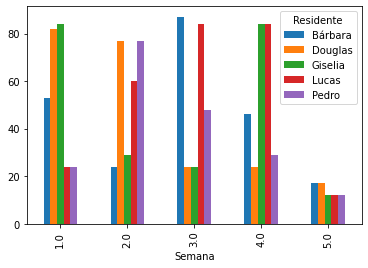

In [58]:
resident_list = list(df_pivot.columns)
pivot = df_pivot.reset_index()
pivot.plot(x="Semana", y=resident_list, kind="bar")
